# Aplicación del Algoritmo de Optimización de Lobo Gris Discreto (DGWO) en la Distribución de Instalaciones con Áreas Desiguales (UAFLP)

## 0. Problema de ejemplo para pruebas (O7)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# O7
n_dptos = 7
departamentos = np.arange(1, n_dptos + 1)
areas_dptos = np.array([16, 16, 16, 36, 9, 9, 9])
fl_materiales = np.array([[0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0],
                          [5, 3, 2, 0, 0, 0, 0],
                          [0, 0, 0, 4, 0, 0, 0],
                          [0, 0, 0, 4, 0, 0, 0],
                          [1, 1, 1, 0, 2, 1, 0]])
lados_inst = np.array([8.54, 13]) # ancho, largo
max_rel_aspecto = 4
nombres_dptos = None
costo_manejo_unitario = None

solucion = np.array([[3, 5, 7, 1, 4, 6, 2], 
                     [0, 0, 1, 0, 0, 0, 1]])

## 1. Definición del modelo UAFLP

### 1.1 Método para la decodificación de la solución

**Entradas**: Array con una solución `np.array([dptos], [bahias])`

Se requieren los siguientes pasos:

* **Identificar bahias**: Retorna una lista con los departamentos en cada bahía: `bahias`.


* **Calcular dimensiones y centroides de los departamentos**:  Retorna una lista con las dimensiones de ancho y largo de cada departamento `lados_dptos` y otra lista con las coordenadas en $x$ y $y$ de los centroides de cada departamento `centroides_dptos`.

In [ ]:
## Identificar bahias
bahias = []
dpts_bahias = []

for ind, bah in enumerate(solucion[1]):
    dpto = solucion[0, ind]

    if ind == 0 or bah == 0:
        dpts_bahias.append(dpto)
        if bah == 1:
            bahias.append(dpts_bahias)
            dpts_bahias = []
    elif bah == 1:
        dpts_bahias.append(dpto)
        bahias.append(dpts_bahias)
        dpts_bahias = []

In [ ]:
bahias

In [ ]:
## Obtener dimensiones de lados y centroides de departamentos
centroides_dptos = [0] * n_dptos
lados_dptos = [0] * n_dptos

contador_ancho = 0
for bah in bahias:
    
    area_bahia = 0
    for dpto in bah:
        area_bahia += areas_dptos[dpto-1]
        
    ancho_bahia = area_bahia / lados_inst[1]
    
    contador_largo = 0
    for dpto in bah:
        largo_dpto = areas_dptos[dpto-1] / ancho_bahia
        lados_dptos[dpto-1] = [ancho_bahia, largo_dpto]
        centro_x = contador_ancho + ancho_bahia / 2
        centro_y = contador_largo + largo_dpto / 2
        centroides_dptos[dpto-1] = [centro_x, centro_y]
        contador_largo += largo_dpto
        
    contador_ancho += ancho_bahia        

In [ ]:
centroides_dptos

In [ ]:
lados_dptos

### 1.2 Método para dibujar el plano de planta de la solución

**Entradas**: 

* Array con una solución `np.array([dptos], [bahias])`
* Lista de los departamentos en cada bahía `bahias`
* Lista con las dimensiones de lados de los departamentos `lados_dptos`
* Lista con las coordenadas de los centroides de los departamentos `centroides_dptos`

Retorna un layout de bloques con la ubicación de los departamentos en el plano de planta, de acuerdo con la solución dada.

In [ ]:
# Dibujar layout de planta de la solucion
if nombres_dptos == None:
    nombres_dptos = [f'Dpto {d}' for d in departamentos]

if lados_inst[0] > lados_inst[1]:
    fig = plt.figure(dpi=300, figsize=(3, 2))
else:
    fig = plt.figure(dpi=300, figsize=(2, 3))
    
plt.rcParams.update({'font.size': 6})
ax = fig.add_subplot(111)
ax.set_xlim([0, lados_inst[0]])
ax.set_ylim([0, lados_inst[1]])
ax.set_xticks([0, lados_inst[0]])
ax.set_yticks([0, lados_inst[1]])

esq_x = 0
for bah in bahias:
    
    esq_y = 0
    for dpt in bah:
        rect = plt.Rectangle((esq_x, esq_y), width=lados_dptos[dpt-1][0],
                            height=lados_dptos[dpt-1][1], facecolor='white',
                            edgecolor='black')
        plt.text(centroides_dptos[dpt-1][0], centroides_dptos[dpt-1][1],
                f'{nombres_dptos[dpt-1]}', horizontalalignment='center',
                verticalalignment='top')
        plt.plot(centroides_dptos[dpt-1][0], centroides_dptos[dpt-1][1],
                color='black', marker=None, markersize=2)
        ax.add_patch(rect)
        
        esq_y += lados_dptos[dpt-1][1]
        
    esq_x += lados_dptos[dpt-1][0]
    
plt.show()

### 1.2 Método para calcular la función *fitness* de la solución

Se requieren los siguientes pasos:

* **Calcular las distancias entre departamentos**: Retorna una matriz triangular inferior con las distancias *rectilíneas*  entre cada par de departamentos: `distancias_dptos`


* **Calcular el costo de manejo de materiales**: Retorna el valor de la función objetivo del modelo: `mhc`.


* **Calcular la función fitness**: Retorna el valor de la función *fitness*, considerando penalizaciones por incumplimiento de la restricción de aspecto máxima definida para cada uno de los departamentos en la instalación: `fitness`.


In [ ]:
# Calcular las distancias rectilíneas entre departamentos
distancias_dptos = np.zeros((n_dptos, n_dptos))

for i in departamentos:
    for j in departamentos[i:]:
        dist_rectil_x = np.abs(centroides_dptos[i-1][0] - centroides_dptos[j-1][0])
        dist_rectil_y = np.abs(centroides_dptos[i-1][1] - centroides_dptos[j-1][1])
        
        distancias_dptos[j-1, i-1] = dist_rectil_x + dist_rectil_y

In [ ]:
distancias_dptos

In [ ]:
# Calcular el costo total de manejo de materiales

# Crear una matriz con el costo de manejo por unidad
matriz_costos_dptos = None
if costo_manejo_unitario == None: 
    matriz_costos_dptos = np.ones((n_dptos, n_dptos))
else:
    matriz_costos_dptos = np.full((n_dptos, n_dptos), costo_manejo_unitario)

    
mhc = np.sum(matriz_costos_dptos * distancias_dptos * fl_materiales)

In [ ]:
mhc

In [ ]:
# Calcular función fitness
k = 3

contador_rompen_restr = 0
for i in solucion[0]:
    tasa_aspecto = max(lados_dptos[i-1][0], lados_dptos[i-1][1]) / min(lados_dptos[i-1][0], lados_dptos[i-1][1])
    
    if tasa_aspecto > max_rel_aspecto:
        contador_rompen_restr += 1
        
fitness = mhc + mhc * (contador_rompen_restr ** k)

In [ ]:
fitness

### 1.3 Creación de la clase `ModeloUAFLP` para su aplicación usando el DGWO

Las clases permiten generar *objetos* que contienen atributos y métodos, que a su vez pueden ser manipulados por otras clases.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class ModeloUAFLP:
    
    # Constructor de la clase (argumentos requeridos para crear la clase)
    def __init__(self, n_dptos:int, areas_dptos:np.ndarray, flujo_materiales:np.ndarray,
                lados_instalacion:np.ndarray, tasa_aspecto_max:int, costo_manejo_unit:float=None,
                nombres_dptos:list=None, archivo_datos:str=None) -> None:
        
        if archivo_datos == None:
            self.n_dptos = n_dptos
            self.departamentos = np.arange(1, self.n_dptos + 1)
            self.areas_dptos = areas_dptos
            self.flujo_materiales = flujo_materiales
            self.lados_instalacion = lados_instalacion # ancho, largo
            self.tasa_aspecto_max = tasa_aspecto_max
            self.nombres_dptos = nombres_dptos
            self.costo_manejo_unit = costo_manejo_unit
            
            # Definir matriz de costo de manejo unitario
            if self.costo_manejo_unit == None:
                matriz_costos_dptos = np.ones((self.n_dptos, self.n_dptos))
            else:
                matriz_costos_dptos = np.full((self.n_dptos, self.n_dptos), self.costo_manejo_unit)
        else: # Crear construcción para extraer datos de archivo de datos
            pass 
                
    # Método para decodificar la solución 
    def decodificar_solucion(self, solucion:np.ndarray):
        self.identificar_bahias(solucion)
        self.calcular_lados_centros()
    
    # Identificar bahías
    def identificar_bahias(self, solucion):
        self.bahias = []
        dpts_bahias = []

        for ind, bah in enumerate(solucion[1]):
            dpto = solucion[0, ind] # Identificar dpto en posicion

            if ind == 0 or bah == 0:
                dpts_bahias.append(dpto) # Añadir dptos en bahía
                if bah == 1:
                    self.bahias.append(dpts_bahias) # Añadir bahía a bahías
                    dpts_bahias = []
            elif bah == 1:
                dpts_bahias.append(dpto) # Añadir dptos en bahía
                self.bahias.append(dpts_bahias) # Añadir bahía a bahías
                dpts_bahias = []
    
    # Calcular dimensiones de lados y centroides de los departamentos
    def calcular_lados_centros(self):
        self.centroides_dptos = [0] * self.n_dptos
        self.lados_dptos = [0] * self.n_dptos

        contador_ancho = 0
        for bah in self.bahias:

            area_bahia = 0
            for dpto in bah:
                area_bahia += self.areas_dptos[dpto-1] # area bahia = suma(areas dptos en bahia)

            ancho_bahia = area_bahia / self.lados_inst[1] # ancho bahia = area de bahia / largo de instalacion

            contador_largo = 0
            for dpto in bah:
                largo_dpto = self.areas_dptos[dpto-1] / ancho_bahia # largo dpto = area dpto / ancho bahia
                self.lados_dptos[dpto-1] = [ancho_bahia, largo_dpto] # Nota: ancho bahia == ancho dpto en bahia
                centro_x = contador_ancho + ancho_bahia / 2
                centro_y = contador_largo + largo_dpto / 2
                self.centroides_dptos[dpto-1] = [centro_x, centro_y]
                contador_largo += largo_dpto

            contador_ancho += ancho_bahia

    # Dibujar layout de planta de la solucion
    def dibujar_layout(self, solucion:np.ndarray):
        if self.nombres_dptos == None:
            self.nombres_dptos = [f'Dpto {d}' for d in self.departamentos]

        self.decodificar_solucion(solucion)

        if self.lados_instalacion[0] > self.lados_instalacion[1]:
            fig = plt.figure(dpi=300, figsize=(6, 4))
        else:
            fig = plt.figure(dpi=300, figsize=(4, 6))

        plt.rcParams.update({'font.size': 6})
        ax = fig.add_subplot(111)
        ax.set_xlim([0, self.lados_instalacion[0]])
        ax.set_ylim([0, self.lados_instalacion[1]])
        ax.set_xticks([0, self.lados_instalacion[0]])
        ax.set_yticks([0, self.lados_instalacion[1]])

        esq_x = 0
        for bah in self.bahias:

            esq_y = 0
            for dpt in bah:
                rect = plt.Rectangle((esq_x, esq_y), width=self.lados_dptos[dpt-1][0],
                                     height=self.lados_dptos[dpt-1][1], facecolor='white',
                                     edgecolor='black')
                plt.text(self.centroides_dptos[dpt-1][0], self.centroides_dptos[dpt-1][1],
                         f'{self.nombres_dptos[dpt-1]}', horizontalalignment='center',
                         verticalalignment='top')
                plt.plot(self.centroides_dptos[dpt-1][0], self.centroides_dptos[dpt-1][1],
                         color='black', marker=None, markersize=2)
                ax.add_patch(rect)

                esq_y += self.lados_dptos[dpt-1][1]

            esq_x += self.lados_dptos[dpt-1][0]

        plt.show()

    # Calcular la función fitness
    def calcular_fitness(self, solucion:np.ndarray):
        self.decodificar_solucion(solucion)
        self.calcular_distancias()
        self.calcular_mhc()

        k = 3

        contador_no_factibles = 0
        for i in solucion[0]:
            tasa_aspecto_dpto = max(self.lados_dptos[i-1][0], self.lados_dptos[i-1][1]) / min(self.lados_dptos[i-1][0], self.lados_dptos[i-1][1])

            if tasa_aspecto_dpto > self.tasa_aspecto_max:
                contador_no_factibles += 1

        fitness = self.mhc + self.mhc * (contador_no_factibles ** k)

        return round(fitness, ndigits=2)

    # Calcular las distancias rectilíneas entre departamentos
    def calcular_distancias(self):
        self.distancias_dptos = np.zeros((self.n_dptos, self.n_dptos))

        for i in self.departamentos:
            for j in self.departamentos[i:]:
                dist_rectil_x = np.abs(self.centroides_dptos[i-1][0] - self.centroides_dptos[j-1][0])
                dist_rectil_y = np.abs(self.centroides_dptos[i-1][1] - self.centroides_dptos[j-1][1])

                self.distancias_dptos[j-1, i-1] = dist_rectil_x + dist_rectil_y

    # Calcular el costo total de manejo de materiales entre departamentos
    def calcular_mhc(self):
        self.matriz_costos_dptos = None

        if self.costo_manejo_unit == None:
            self.matriz_costos_dptos = np.ones((self.n_dptos, self.n_dptos))
        else:
            self.matriz_costos_dptos = np.full((self.n_dptos, self.n_dptos), self.costo_manejo_unit)

        self.mhc = np.sum(self.matriz_costos_dptos * self.distancias_dptos * self.flujo_materiales)

In [3]:
uaflp = ModeloUAFLP(n_dptos=n_dptos, areas_dptos=areas_dptos, flujo_materiales=fl_materiales, lados_instalacion=lados_inst, tasa_aspecto_max=max_rel_aspecto)

## 2. Algoritmo de Optimización de Lobo Gris Discreto (DGWO)

### 2.1 Definir parámetros del algoritmo

In [ ]:
from copy import deepcopy

In [ ]:
tam_manada = 12 # max 12
n_lideres = 3 # 1 o 3
theta_1 = 0.4 # < 1
theta_2 = 0.2 # < 1
theta_3 = 0.6 # alpha influence < 1

### 2.2 Inicializar población e identificar líderes

Se requieren los siguientes pasos:

* **Generar lobos en manada**: Retorna un array con los lobos (soluciones) generadas aleatoriamente, de acuerdo con el parámetro `tam_manada`: `manada`, y una lista con el valor de la función *fitness* para cada solución: `fit_manada`.

* **Identificar líderes de la manada**: Retorna una lista con los lobos (soluciones) con mejor función *fitness* de la manada en el siguiente orden: `lobos_lideres = [alpha, beta, delta]`, y una lista con el valor de la función *fitness* correspondiente: `fit_lideres`. Este método, además, remueve los lobos líderes de la manada y su respectiva función *fitness*.

In [ ]:
# Generar lobos en manada
manada = [0] * tam_manada
fit_manada = [0] * tam_manada

for lobo_ind in range(tam_manada):
    lobo_dpts = list(np.random.permutation(departamentos))
    lobo_bahs = list(np.random.randint(0, 2, n_dptos-1)) + [1]
    manada[lobo_ind] = np.array([lobo_dpts, lobo_bahs])
    fit_manada[lobo_ind] = uaflp.calcular_fitness(manada[lobo_ind])


In [ ]:
for lobo, fit in zip(manada, fit_manada):
    print(lobo, fit)

In [ ]:
# Identificar lobos líderes
lobos_lideres = [0] * n_lideres 
fit_lideres = [0] * n_lideres

for ind in range(n_lideres):

    p_min = np.argmin(fit_manada)
    lobos_lideres[ind] = manada[p_min]
    fit_lideres[ind] = fit_manada[p_min]
    manada.pop(p_min)
    fit_manada.pop(p_min)

In [ ]:
for lobo, fit in zip(lobos_lideres, fit_lideres):
    print(lobo, fit)

In [ ]:
for lobo, fit in zip(manada, fit_manada):
    print(lobo, fit)

### 2.3 Realizar comportamiento de búsqueda de la presa

**Buscar presa**: Este método actualiza la lista de soluciones (`manada`), la lista con los valores fitness de la manada (`fit_manada`), la lista de mejores soluciones (`lobos_lideres`) y su función fitness (`fit_lideres`), al realizar movimientos o modificaciones aleatorias en los elementos de las soluciones en la manada.

Este método consiste en los siguientes pasos:

* Identificar el tamaño del movimiento a realizar `tam_movimiento`, el cual está relacionado con el valor del parámetro `theta_1`.

* Por cada lobo de la manada: 

    - Realizar un movimiento aleatorio (tanto para el componente de departamentos como el de bahías) de tamaño `tam_movimiento`. Es decir, realizar una modificación en el orden de los departamentos/bahías, dada por un intercambio aleatorio entre estos, con el fin de crear una nueva posición del lobo en la manada: `nuevo_lobo`.

    - Calcular la función fitness de `nuevo_lobo`: `fit_nuevo_lobo` y compararla con aquella del lobo alpha (`lobos_lideres[0]`) o del lobo actual en la manada.

    - En caso de que `fit_nuevo_lobo` sea mejor que aquella del lobo alpha, incluir esta solución como nuevo lobo alpha y desplazar al lobo delta `lobos_lideres[-1]` a la manada. Este proceso provoca que se inicie inmediatamente el comportamiento de ataque.

    - En caso de que `fit_nuevo_lobo` sea mejor que la del lobo actual, simplemente se reemplaza al nuevo lobo en la manada.

In [ ]:
# Comportamiento de buscar presa
tam_movimiento = np.floor(n_dptos * theta_1).astype(int)

for ind, lobo in enumerate(manada):

    lobo_dp = deepcopy(lobo[0])
    lobo_bh = deepcopy(lobo[1])

    # Metodo para realizar el movimiento (dp)
    pos_inicio, pos_fin = np.random.randint(0, n_dptos - tam_movimiento + 1, 2)
    pos_movimiento = np.arange(pos_inicio, pos_inicio + tam_movimiento)
    movimiento = lobo_dp[pos_movimiento]
    lobo_dp = np.delete(lobo_dp, pos_movimiento)
    lobo_dp = np.insert(lobo_dp, pos_fin, movimiento)

    # Metodo para realizar el movimiento (bh)
    pos_inicio, pos_fin = np.random.randint(0, n_dptos - tam_movimiento + 1, 2)
    pos_movimiento = np.arange(pos_inicio, pos_inicio + tam_movimiento)
    movimiento = lobo_bh[pos_movimiento]
    lobo_bh = np.delete(lobo_bh, pos_movimiento)
    lobo_bh = np.insert(lobo_bh, pos_fin, movimiento)

    if lobo_bh[-1] != 1:
        lobo_bh[-1] = 1

    nuevo_lobo = np.array([list(lobo_dp), list(lobo_bh)])
    fit_nuevo_lobo = uaflp.calcular_fitness(nuevo_lobo)

    # Comparar nuevo fitness con el de lobo alpha y fitness actual
    if fit_nuevo_lobo < fit_lideres[0]:

        # Agregar nuevo alpha
        lobos_lideres.insert(0, nuevo_lobo)        
        fit_lideres.insert(0, fit_nuevo_lobo)

        # Desplazar antiguo lobo delta a la manada
        manada[ind] = lobos_lideres[-1]
        fit_manada[ind] = fit_lideres[-1]

        lobos_lideres.pop()
        fit_lideres.pop()
        break # Romper busqueda para iniciar ataque
    elif fit_nuevo_lobo < fit_manada[ind]:

        # Reemplazar nueva posicion de lobo en manada
        manada[ind] = nuevo_lobo
        fit_manada[ind] = fit_nuevo_lobo  

In [ ]:
for lobo, fit in zip(lobos_lideres, fit_lideres):
    print(lobo, fit)

In [ ]:
for lobo, fit in zip(manada, fit_manada):
    print(lobo, fit)

### 2.4 Atacar presa (recortar distancia con el líder)

**Atacar presa**: Este método actualiza la lista de soluciones (`manada`), la lista con los valores fitness de la manada (`fit_manada`), la lista de mejores soluciones (`lobos_lideres`) y su función fitness (`fit_lideres`), al reducir las distancias entre los elementos de las soluciones en la manada, con respecto a los lobos líderes.

Este método consiste en los siguientes pasos:

* Calcular la distancia mínima requerida (`da`), la cual está relacionada con el valor del parámetro `theta_2`

* Por cada lobo de la manada:

    - Seleccionar el lobo líder, de acuerdo con el parámetro de influencia del lobo alpha (`theta_3`), el cual se usa para comparar cada lobo en la manada.

    - Calcular la distancia/diferencia entre los elementos del lobo y líder.

    - Mientras que la distancia < `da`, reducir la distancia de cada elemento con respecto al líder para crear una nueva posición del lobo: `nuevo_lobo`.

    - Calcular la función fitness de `nuevo_lobo`: `fit_nuevo_lobo` y compararla con aquella del lobo alpha (`lobos_lideres[0]`) o del lobo actual en la manada.

    - En caso de que `fit_nuevo_lobo` sea mejor que aquella del lobo alpha, incluir esta solución como nuevo lobo alpha y desplazar al lobo delta `lobos_lideres[-1]` a la manada. Este proceso provoca que se inicie inmediatamente el comportamiento de ataque.

    - En caso de que `fit_nuevo_lobo` sea mejor que la del lobo actual, simplemente se reemplaza al nuevo lobo en la manada.

In [ ]:
# Comportamiento de atacar presa
da = np.floor(n_dptos * theta_2)

# Metodo para calcular la distancia con el lider
def calcular_dist_lider(elem_lobo, elem_lider):

    distancia = 0
    for ind in range(len(elem_lider)):
        if elem_lider[ind] != elem_lobo[ind]:
            distancia += 1

    return distancia

def reducir_dist_dptos(elem_lobo, elem_lider, ind_actual):

    dpto_lobo = elem_lobo[ind_actual]
    dpto_lider = elem_lider[ind_actual]
    if dpto_lobo != dpto_lider:
        pos_cambio = np.where(elem_lobo == dpto_lider)[0]
        elem_lobo[ind_actual] = dpto_lider
        elem_lobo[pos_cambio] = dpto_lobo

    return elem_lobo

def reducir_dist_bahias(elem_lobo, elem_lider, ind_actual):

    if elem_lobo[ind_actual] != elem_lider[ind_actual]:
        elem_lobo[ind_actual] = elem_lider[ind_actual]

    return elem_lobo

for ind_md, lobo in enumerate(manada):

    # Seleccionar lider para reducir distancia
    rand = np.random.random()
    if rand < theta_3:
        lider = lobos_lideres[0]
    elif rand < (theta_3 + (1 - theta_3)/2):
        lider = lobos_lideres[1]
    else:
        lider = lobos_lideres[2]
    
    nuevo_lobo = deepcopy(lobo)

    # Metodos para calcular y reducir la distancia (dptos) con el lider
    dist_dptos = calcular_dist_lider(nuevo_lobo[0], lider[0])

    ind_dp = 0
    while dist_dptos > da:
        
        nuevo_lobo[0] = reducir_dist_dptos(nuevo_lobo[0], lider[0], ind_dp)
        dist_dptos = calcular_dist_lider(nuevo_lobo[0], lider[0])
        ind_dp += 1

    dist_bahias = calcular_dist_lider(nuevo_lobo[1], lider[1])

    ind_bh = 0
    while dist_bahias > da:

        nuevo_lobo[1] = reducir_dist_bahias(nuevo_lobo[1], lider[1], ind_bh)
        dist_bahias = calcular_dist_lider(nuevo_lobo[1], lider[1])
        ind_bh += 1

    fit_nuevo_lobo = uaflp.calcular_fitness(nuevo_lobo)

    # Comparar nuevo fitness con el de lobo alpha y fitness actual
    if fit_nuevo_lobo < fit_lideres[0]:

        # Agregar nuevo alpha
        lobos_lideres.insert(0, nuevo_lobo)        
        fit_lideres.insert(0, fit_nuevo_lobo)

        # Desplazar antiguo lobo delta a la manada
        manada[ind_md] = lobos_lideres[-1]
        fit_manada[ind_md] = fit_lideres[-1]

        lobos_lideres.pop()
        fit_lideres.pop()

    elif fit_nuevo_lobo < fit_manada[ind_md]:

        # Reemplazar nueva posicion de lobo en manada
        manada[ind_md] = nuevo_lobo
        fit_manada[ind_md] = fit_nuevo_lobo  
    

### 2.5 Creación de la clase `AlgLoboGris` para su aplicación al UAFLP

Las clases permiten generar *objetos* que contienen atributos y métodos, que a su vez pueden ser manipulados por otras clases.

In [18]:
import numpy as np
from copy import deepcopy
from time import time

class AlgLoboGris(ModeloUAFLP):

    # Constructor de la clase (hereda las caracteristicas de la clase ModeloUAFLP)
    def __init__(self, n_dptos: int, areas_dptos: np.ndarray, flujo_materiales: np.ndarray, lados_instalacion: np.ndarray, tasa_aspecto_max: int, costo_manejo_unit: float = None, nombres_dptos: list = None, archivo_datos: str = None) -> None:
        super().__init__(n_dptos, areas_dptos, flujo_materiales, lados_instalacion, tasa_aspecto_max, costo_manejo_unit, nombres_dptos, archivo_datos)

    # Correr algoritmo de lobo gris
    def optimizacion_lobo_gris(self, tam_manada:int, n_lideres:int, theta_1:float, theta_2:float, theta_3:float=None, tiempo_lim:int=3600):
        
        if tam_manada not in range(n_lideres + 1, 16):
            raise ValueError('Parameter value tam_manada should be greater than n_lideres and lower than 15')
        
        if n_lideres not in {1, 3}:
            raise ValueError('Parameter value n_lideres should be equal to 1 or equal to 3')

        if theta_1 <= 0 or theta_1 >= 1 or theta_2 <= 0 or theta_2 >= 1 or theta_3 <= 0 or theta_3 >= 1:
            raise ValueError('Parameter values theta_1, theta_2 and theta_3 should be greater than 0 and lower than 1')

        if n_lideres == 1 and theta_3 != None:
            raise AttributeError('Parameter theta_3 has no influence when n_lideres is 1 and should be None')

        timeout = time() + tiempo_lim
        lobos_sols = []
        fit_sols = []

        self.generar_manada(tam_manada)
        self.identificar_lideres(n_lideres)
        while time() < timeout:
            
            self.buscar_presa(theta_1)
            self.atacar_presa(n_lideres, theta_2, theta_3)

            lobos_sols.append(self.lobos_lideres[0])
            fit_sols.append(self.fit_lideres[0])

        return {'sols_uaflp': lobos_sols, 'vals_fitness': fit_sols}

    # Inicializar poblacion de la manada
    def generar_manada(self, tam_manada):

        self.manada = [0] * tam_manada
        self.fit_manada = [0] * tam_manada

        for lobo_ind in range(tam_manada):
            lobo_dpts = list(np.random.permutation(self.departamentos))
            lobo_bahs = list(np.random.randint(0, 2, self.n_dptos - 1)) + [1]
            self.manada[lobo_ind] = np.array([lobo_dpts, lobo_bahs])
            self.fit_manada[lobo_ind] = self.calcular_fitness(self.manada[lobo_ind])

    # Identificar lobos lideres ([alpha]) si n_lideres = 1, ([alpha, beta, delta]) si n_lideres = 3
    def identificar_lideres(self, n_lideres):

        self.lobos_lideres = [0] * n_lideres
        self.fit_lideres = [0] * n_lideres

        for ind in range(n_lideres):
            p_min = np.argmin(self.fit_manada)
            self.lobos_lideres[ind] = self.manada[p_min]
            self.fit_lideres[ind] = self.fit_manada[p_min]
            self.manada.pop(p_min)
            self.fit_manada.pop(p_min)

    # Ejecutar comportamiento de busqueda de la presa
    def buscar_presa(self, theta_1):
        
        tam_movimiento = np.floor(self.n_dptos * theta_1).astype(int)
        
        for ind, lobo in enumerate(self.manada):

            lobo_dp = deepcopy(lobo[0])
            lobo_bh = deepcopy(lobo[1])

            # Realizar movimiento en elementos de lobos
            lobo_dp = self.realizar_movimiento(lobo_dp, tam_movimiento)
            lobo_bh = self.realizar_movimiento(lobo_bh, tam_movimiento)

            if lobo_bh[-1] != 1:
                lobo_bh[-1] = 1

            # Calcular funcion fitness del nuevo lobo
            nuevo_lobo = np.array([list(lobo_dp), list(lobo_bh)])
            fit_nuevo_lobo = self.calcular_fitness(nuevo_lobo)

            # Comparar y reemplazar (si aplica) nuevo lobo generado
            if fit_nuevo_lobo < self.fit_lideres[0]:

                self.insertar_nuevo_lider(nuevo_lobo, fit_nuevo_lobo, ind)
                break # Romper busqueda para iniciar ataque

            elif fit_nuevo_lobo < self.fit_manada[ind]:

                # Reemplazar nuevo lobo en manada
                self.manada[ind] = nuevo_lobo
                self.fit_manada[ind] = fit_nuevo_lobo

    # Ejecutar comportamiento de ataque a la presa
    def atacar_presa(self, n_lideres, theta_2, theta_3=None):
        
        da = np.floor(self.n_dptos * theta_2)

        for ind_md, lobo in enumerate(self.manada):

            nuevo_lobo = deepcopy(lobo)
            lider = None
            if n_lideres == 1:
                lider = self.lobos_lideres[0]
            else:
                rand = np.random.random()
                if rand < theta_3:
                    lider = self.lobos_lideres[0]
                elif rand < (theta_3 + (1 - theta_3)/2):
                    lider = self.lobos_lideres[1]
                else:
                    lider = self.lobos_lideres[2]

            # Calcular y reducir distancia con el lider para elemento con dptos
            dist_dptos = self.calcular_dist_lider(nuevo_lobo[0], lider[0])

            ind_dp = 0
            while dist_dptos > da:

                nuevo_lobo[0] = self.reducir_dist_dptos(nuevo_lobo[0], lider[0], ind_dp)
                dist_dptos = self.calcular_dist_lider(nuevo_lobo[0], lider[0])
                ind_dp += 1

            # Calcular y reducir distancia con el lider para elemento de bahias
            dist_bahias = self.calcular_dist_lider(nuevo_lobo[1], lider[1])

            ind_bh = 0
            while dist_bahias > da:

                nuevo_lobo[1] = self.reducir_dist_bahias(nuevo_lobo[1], lider[1], ind_bh)
                dist_bahias = self.calcular_dist_lider(nuevo_lobo[1], lider[1])
                ind_bh += 1

            fit_nuevo_lobo = self.calcular_fitness(nuevo_lobo)

            # Comparar y reemplazar (si aplica) nuevo lobo generado
            if fit_nuevo_lobo < self.fit_lideres[0]:

                 self.insertar_nuevo_lider(nuevo_lobo, fit_nuevo_lobo, ind_md)

            elif fit_nuevo_lobo < self.fit_manada[ind_md]:

                # Reemplazar nuevo lobo en manada
                self.manada[ind_md] = nuevo_lobo
                self.fit_manada[ind_md] = fit_nuevo_lobo

    # Metodo para realizar movimiento en elemento de lobos
    def realizar_movimiento(self, elem_lobo, tam_movimiento):

        pos_inicio, pos_fin = np.random.randint(0, self.n_dptos - tam_movimiento + 1, 2)
        pos_movimiento = np.arange(pos_inicio, pos_inicio + tam_movimiento)
        movimiento = elem_lobo[pos_movimiento]
        elem_lobo = np.delete(elem_lobo, pos_movimiento)
        elem_lobo = np.insert(elem_lobo, pos_fin, movimiento)

        return elem_lobo
    
    # Metodo para reemplazar nuevo lider en lideres y desplazar lobo delta a manada
    def insertar_nuevo_lider(self, nuevo_lobo, fit_nuevo_lobo, ind_manada):
        
        # Agregar nuevo alpha a los lideres
        self.lobos_lideres.insert(0, nuevo_lobo)
        self.fit_lideres.insert(0, fit_nuevo_lobo)

        # Desplazar antiguo lobo delta a la manada
        self.manada[ind_manada] = self.lobos_lideres[-1]
        self.fit_manada[ind_manada] = self.fit_lideres[-1]

        # Eliminar antiguo lobo delta de los lideres
        self.lobos_lideres.pop()
        self.fit_lideres.pop()

    # Metodo para calcular distancia entre lobo en manada y lobo lider
    def calcular_dist_lider(self, elem_lobo, elem_lider):

        distancia = 0
        for ind in range(len(elem_lider)):
            if elem_lobo[ind] != elem_lider[ind]:
                distancia += 1

        return distancia
    
    # Metodo para reducir la distancia entre el lobo en manada y lobo lider (para elemento con dptos)
    def reducir_dist_dptos(self, elem_lobo, elem_lider, ind_actual):

        dpto_lobo = elem_lobo[ind_actual]
        dpto_lider = elem_lider[ind_actual]
        if dpto_lobo != dpto_lider:
            pos_cambio = np.where(elem_lobo == dpto_lider)[0]
            elem_lobo[ind_actual] = dpto_lider
            elem_lobo[pos_cambio] = dpto_lobo

        return elem_lobo
    
    # Metodo para reducir la distancia entre el lobo en manada y lobo lider (para elemento con bahias)
    def reducir_dist_bahias(self, elem_lobo, elem_lider, ind_actual):

        if elem_lobo[ind_actual] != elem_lider[ind_actual]:
            elem_lobo[ind_actual] = elem_lider[ind_actual]

        return elem_lobo
    

## 3. Celda principal: Aplicación del `AlgLoboGris` en el `ModeloUAFLP`

Antes de correr esta celda, se deben definir las clases para el `ModeloUAFLP` en la sección 1.3 y para el `AlgLoboGris` en la sección 2.5. Del mismo modo, se debe definir la instacia de datos a usar (Por ahora, es correr la celda en la sección 0.).

In [19]:
lobo_gris = AlgLoboGris(n_dptos=n_dptos, areas_dptos=areas_dptos, flujo_materiales=fl_materiales, lados_instalacion=lados_inst, tasa_aspecto_max=max_rel_aspecto)

n_iters = 1

while n_iters > 0:

    resultados_gwo = lobo_gris.optimizacion_lobo_gris(tam_manada=10, n_lideres=3, theta_1=0.4, theta_2=0.2, theta_3=0.6, tiempo_lim=1200)

    print(resultados_gwo['vals_fitness'])
    
    n_iters -= 1

[155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 155.79, 150.29, 150.29, 150.29, 150.29, 148.18, 148.18, 148.18, 148.18, 148.18, 148.18, 148.18, 148.18, 148.18, 148.18, 148.18, 148.18, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96, 139.96,

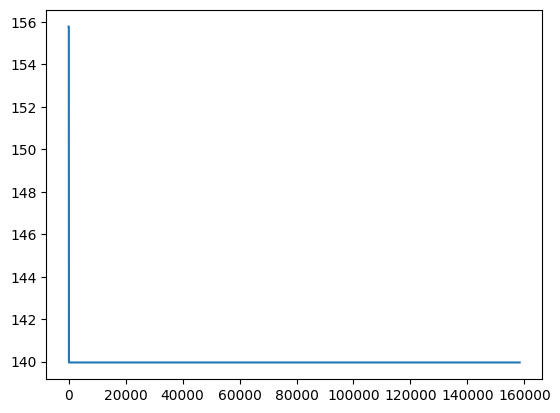

In [20]:
import matplotlib.pyplot as plt

plt.plot(resultados_gwo['vals_fitness'])
plt.show()

In [21]:
resultados_gwo['vals_fitness'][-1]

139.96

In [22]:
mejor = lobo_gris.calcular_fitness(solucion)
mejor

134.19

In [23]:
gap = (resultados_gwo['vals_fitness'][-1] - mejor)/mejor
gap * 100

4.2998733139578285